# Linear Least Squares

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

## Introduction

In the previous chapter we saw methods to solve systems of linear equations with the same amount of unknowns as equations. For a nonsingular problem, there was only one solution, for which each of the equations was exactly satisfied. 

However, in a scientific experiment, you'll often have far more measurement data points than unknown variables in the function you want to fit to your data. In the terminology of the previous chapter, you have a system

$$\mathbf{Ax}=\mathbf{b}$$

In which $\mathbf{A}$ no longer is a square matrix but an $m\times n$ matrix with $m>n$. We call this an *overdetermined* problem. Typically, all measurement data also contain a certain amount of noise, such that there no longer exists a solution that exactly satisfies all equations.

Instead, we want to model the data as closely as possible by minimizing the norm of the residual $\mathbf{r}=\mathbf{b}-\mathbf{Ax}$ as a function of $\mathbf{x}$.

In principle, any norm can be used for this purpose, but the best choice is the Euclidean norm, which also gives the method of least squares its name: the solution is the vector $\mathbf{x}$ that minimizes the sum of squares of differences between the components of the left and right sides of the linear system.

To reflect the lack of an exact equality, we write such a problem as 
$\mathbf{Ax}\cong\mathbf{b}$.

> **Example: curve fitting**
>
> Given data points $(t_i,y_i)$, $i=1,\ldots, m$ we wish to find the set of parameters $\mathbf{x}$ that gives the best fit to the data by a model function $f(t,\mathbf{x})$ in the sense:
> 
> $$\min_{\mathbf{x}}\sum_{i=1}^{m}(y_i-f(t_i,\mathbf{x}))^2$$
>
> A data-fitting problem is *linear* if the function $f$ is linear in the components of the parameter vector $\mathbf{x}$. In this chapter, we will limit ourselves to *linear* least squares, and leave *nonlinear* least squares for the chapter on *optimization*. 
>
> For instance, when fitting a quadratic polynomial (3 parameters) to a dataset containing 6 data points $(t_1,y_1),\ldots, (t_6,y_6)$ the problem has the form
>
> $$ \mathbf{Ax}=  \begin{bmatrix}
1 & t_1 & t_1^2 \\
1 & t_2 & t_2^2 \\
1 & t_3 & t_3^2 \\
1 & t_4 & t_4^2 \\
1 & t_5 & t_5^2 \\
1 & t_6 & t_6^2 
\end{bmatrix}   \begin{bmatrix} x_1\\x_2\\x_3 \end{bmatrix} \cong \begin{bmatrix} y_1\\y_2\\y_3\\y_4\\y_5\\y_6 \end{bmatrix}=\mathbf{b}$$
>
> Such a matrix, whose columns are successive powers of some independent variable is called a *Vandermonde matrix*.

> **Example: projectile trajectory**
>
> Suppose we throw a ball in the air and record the height ($y$) of the ball as a function of time ($t$). Thanks to the laws of kinematics we know that the following relation holds:
> 
> $$
    f(t) = y(t) = y_0 + v_0t + \frac{1}{2}at^2
$$
>
> From the experiment we obtain the following 10 data points:
>
> | t |  0  |  1  |  2  |  3  |  4  |  5  |   6  |  7  |  8  |  9  |  10  | 
> |:-:|:---:|:---:|:---:|:---:|:---:|:---:|:----:|:---:|:---:|:---:|:----:|
> | y | 2.9 | 4.8 | 7.1 | 7.7 | 9.4 | 9.6 | 10.2 | 8.3 | 9.0 | 6.6 | 4.1  |
>
> This corresponds to the linear system
> 
> $$ \mathbf{Ax}=  \begin{bmatrix}
1 & 0 & 0 \\
1 & 1 & 1 \\
1 & 2 & 4 \\
1 & 3 & 9 \\
1 & 4 & 16 \\
1 & 5 & 25 \\
\vdots & \vdots & \vdots \\
1 & 10 & 100
\end{bmatrix}   \begin{bmatrix} x_1\\x_2\\x_3 \end{bmatrix} \cong \begin{bmatrix} 2.9\\ 4.8 \\ 7.1 \\ 7.7 \\ 9.4 \\ 9.6 \\ \vdots \\ 4.1 \end{bmatrix}=\mathbf{b}$$
>
> The solution to this system (which we'll learn how to find in the remainder of this chapter) is
>
> $$\
\mathbf{x}\approx [ 2.60489151 \quad 2.65037296 \quad -0.2460373]^\intercal,
$$
> corresponding to the polynomial 
>
> $$ f(t)=2.60 + 2.65 t -0.25 t^2 $$
>
> from which it follows that the experiment was apparently performed on Pluto ($g = 0.5\, \mathrm{m/s}^2$) and not on earth ($g = 9.8\, \mathrm{m/s}^2$). 


Although we still don't know how the computer solves this kind of problem, we can already illustrate how you can perform this kind of least squares fitting using `scipy`. 
We illustrate this using the same example:

[[  1   0   0]
 [  1   1   1]
 [  1   2   4]
 [  1   3   9]
 [  1   4  16]
 [  1   5  25]
 [  1   6  36]
 [  1   7  49]
 [  1   8  64]
 [  1   9  81]
 [  1  10 100]]
[ 2.6048951   2.65037296 -0.2460373 ]


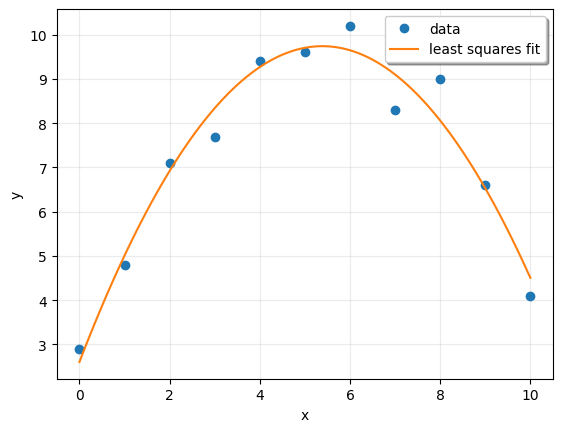

In [2]:
def lstsq_example1():
    x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    y = np.array([2.9, 4.8, 7.1, 7.7, 9.4, 9.6, 10.2, 8.3, 9.0, 6.6, 4.1])

    # We want to fit a quadratic polynomial of the form
    # y = a + b*x +c*x**2 to this data.
    # We first form the "design matrix" M,
    # with a constant column of 1s, a column containing x and a column x**2:
    M = x[:, np.newaxis] ** [0, 1, 2]
    print(M)

    # We want to find the least-squares solution to M.dot(p) = y,
    # where p is a vector with length 3 that holds the parameters a and b an c.
    p, res, rnk, s = linalg.lstsq(M, y)

    print(p)

    plt.close("lstsq-example-1")
    fig, ax = plt.subplots(num="lstsq-example-1")
    ax.plot(x, y, "o", label="data")
    xx = np.linspace(0, 10, 101)
    yy = p[0] + p[1] * xx + p[2] * xx**2
    ax.plot(xx, yy, label="least squares fit")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(framealpha=1, shadow=True)
    ax.grid(alpha=0.25)


lstsq_example1()

## Normal Equations

We wish to minimize the squared Euclidean norm of the residual vector

$$\mathbf{r}=\mathbf{b}-\mathbf{Ax}$$

We define an objective function 

$$
\phi(\mathbf{x})=\|\mathbf{r}\|^2_2=\mathbf{r}^\intercal\mathbf{r} 
=(\mathbf{b}-\mathbf{Ax})^\intercal(\mathbf{b}-\mathbf{Ax})=
\mathbf{b}^\intercal\mathbf{b}-\mathbf{x}^\intercal\mathbf{A}^\intercal\mathbf{b}-\mathbf{b}^\intercal\mathbf{Ax}+\mathbf{x}^\intercal\mathbf{A}^\intercal\mathbf{Ax}
$$

To minimize this function, we want to find a point which satisfies $\nabla\phi(\mathbf{x})=\mathbf{0}$
which is true for

$$
\mathbf{0}=\nabla\phi(\mathbf{x})=2\mathbf{A}^\intercal\mathbf{Ax}-2\mathbf{A}^\intercal\mathbf{b}
$$

> Where we used the identity
> - $(\mathbf{BA})^\intercal=\mathbf{A}^\intercal\mathbf{B}^\intercal$
>
> and
>
> - $\nabla(\mathbf{x}^\intercal\mathbf{A}^\intercal\mathbf{Ax})=2\mathbf{A}^\intercal\mathbf{Ax}$
> - $\nabla(\mathbf{b}^\intercal\mathbf{Ax})=\mathbf{A}^\intercal\mathbf{b}$
> - $\nabla(\mathbf{x}^\intercal\mathbf{A}^\intercal\mathbf{b})=\mathbf{A}^\intercal\mathbf{b}$
> - $\nabla(\mathbf{b}^\intercal\mathbf{b})=0$

In other words, to minimize $\mathbf{x}$ for $\phi$ we need to satisfy the $n \times n$ symmetric linear system

$$
\mathbf{A}^\intercal\mathbf{Ax}=\mathbf{A}^\intercal\mathbf{b}
$$

This system is known as the **normal equations**. 
The solution is unique if and only if the columns of A are linearly independent, i.e., rank$(\mathbf{A})=n$. In this case, the matrix $\mathbf{A}^\intercal\mathbf{A}$ is positive definite and symmetric, and the linear system can be solved efficiently with Cholesky factorization.

When some columns of $\mathbf{A}$ are linearly dependent, a manifold of solutions exists, i.e. rank$(\mathbf{A})<n$. In this case, the matrix $\mathbf{A}^\intercal\mathbf{A}$ is positive semi-definite (some eigenvalues are zero) and the minimum of $\phi$ becomes degenerate.

## Problem Transformations

There are several methods to solve a least-square system, but they all amount to the same strategy: to transform it into a square (ultimately triangular) linear system for which we can compute the exact solution using the methods we saw earlier.

Because  $\mathrm{cond}(\mathbf{A}^\intercal\mathbf{A})=\left[\mathrm{cond}(\mathbf{A})\right]^2$, solving the normal equations is not a stable algorithm to solve the least squares problem. 

Therefore, we'll see methods to obtain the solution without explicitly calculating $\mathbf{A}^\intercal\mathbf{A}$.

To this end, we want to transform our linear system to a form that is simpler to solve (we'll see below that a triangular system is a suitable target). However, reducing a matrix using Gaussian Elimination is not an option in this context, as it does not preserve the Euclidean norm and therefore also not the least square solution.

### Orthogonal transformations

We need a type of linear transformation which does preserve the Euclidean norm.

A square real matrix $\mathbf{Q}$ is *orthogonal* if its columns are *orthonormal*, meaning that $\mathbf{Q}^\intercal\mathbf{Q}=\mathbf{I}$.

Such an **orthogonal transformation** $\mathbf{Q}$ preserves the Euclidean norm of any vector $\mathbf{v}$:

$$
\|\mathbf{Qv}\|^2_2=(\mathbf{Qv})^\intercal\mathbf{Qv}=\mathbf{v}^\intercal\mathbf{Q}^\intercal\mathbf{Q}\mathbf{v}=\mathbf{v}^\intercal\mathbf{v}=\|\mathbf{v}\|^2_2
$$

Orthogonal matrices are very useful in numerical computations because their norm-preserving property means that they do not amplify errors, and can e.g. be used to solve square linear systems without requiring pivoting for numerical stability. 

On the other hand, orthogonalization methods are computationally more expensive than methods based on Gaussian elimination, so their superior numerical properties come at a price that may or may not be worthwhile.

### Triangular least squares problems

Before going into detail on how we'll transform our system, let's see why triangular systems are a suitable target for our transformation.

Consider a least squares system having an upper triangular matrix. In the overdetermined case $m>n$, such a problem has the form

$$
\begin{bmatrix}\mathbf{R}\\\mathbf{O}\end{bmatrix}\mathbf{x}\cong\begin{bmatrix}\mathbf{c}_1\\\mathbf{c}_2\end{bmatrix}$$

with $\mathbf{R}$ an $n\times n$ upper triangular matrix and $\mathbf{O}$ a $(m-n)\times n$ null matrix.

The least squares residual is given by 

$$
\|\mathbf{r}\|_2^2=\|\mathbf{c}_1-\mathbf{Rx}\|^2_2+\|\mathbf{c}_2\|^2_2
$$

If we solve the triangular system $\mathbf{Rx}=\mathbf{c}_1$ (which can easily be achieved with back-substitution) we have found the least squares solution $\mathbf{x}$ and we can conclude that the minimum sum of squares is 

$$\|\mathbf{r}\|_2^2=\|\mathbf{c}_2\|^2_2$$

Design matrix A (5×2):
[[1. 0.]
 [1. 1.]
 [1. 2.]
 [1. 3.]
 [1. 4.]]

Rechterlid b (5×1):
[1.  2.5 3.8 5.2 6.1]

Probleem: 5 vergelijkingen, 2 onbekenden → overdetermined (m > n)

Na QR-decompositie:
Q is 5×5 orthogonaal
R_full is 5×2

Na splitting van R en c = Q'b:
R (2×2, bovendriehoekig):
[[-2.23606798 -4.47213595]
 [ 0.          3.16227766]]

c₁ (2×1): [-8.31817288  4.07933818]
c₂ (3×1): [ 0.14301271  0.28496943 -0.07307386]

✓ Oplossing van Rx = c₁: x = [1.14 1.29]
  Dit geeft de best-fit lijn: y = 1.140 + 1.290x

📊 Foutdecompositie:
||c₁ - Rx||² = 0.00e+00  ← We kunnen dit perfect oplossen!
||c₂||²      = 0.1070   ← Dit kunnen we NOOIT wegwerken!
──────────────────────────────────────────────────
Totale fout² = 0.1070
Totale fout  = 0.3271


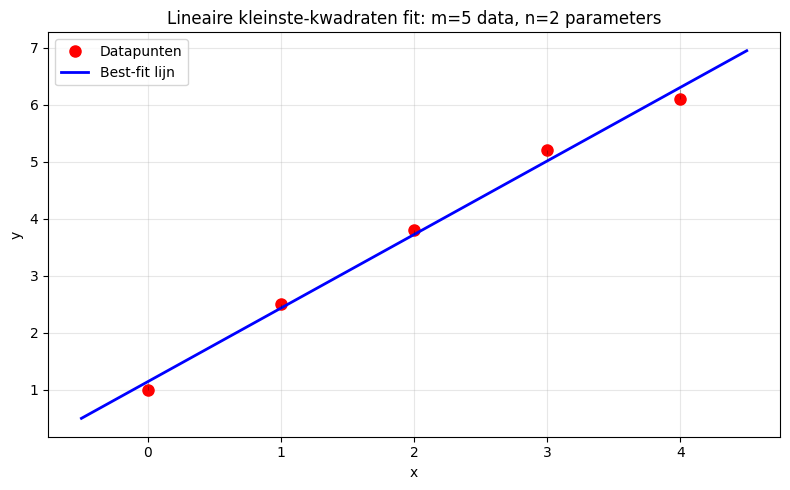


💡 Interpretatie:
  • c₁ vectorbevatten de '2 essentiële' informatie
  • c₂ bevat de '3 extra' informatie die we niet kunnen uitleggen
  • De best-fit oplossing x maakt c₁ - Rx = 0
  • Maar c₂ blijft altijd niet-nul → dat is onze onvermijdbare fout!


In [5]:

# Concreet voorbeeld: intuïtie van de foutdecompositie
# Stel: we willen een lijn y = a + bx fitten door 5 datapunten

import matplotlib.pyplot as plt

# Synthethische data: een lijn met ruis
np.random.seed(42)
x_data = np.array([0, 1, 2, 3, 4], dtype=float)
y_data = np.array([1.0, 2.5, 3.8, 5.2, 6.1], dtype=float)  # ongeveer y = 1 + 1.2x + ruis

# Design matrix: A is 5×2 (5 vergelijkingen, 2 onbekenden)
A = np.column_stack([np.ones(5), x_data])
b = y_data.reshape(-1, 1)

print("Design matrix A (5×2):")
print(A)
print(f"\nRechterlid b (5×1):\n{b.flatten()}")
print(f"\nProbleem: {5} vergelijkingen, {2} onbekenden → overdetermined (m > n)")

# QR-decompositie
Q, R_full = linalg.qr(A)
print(f"\nNa QR-decompositie:")
print(f"Q is 5×5 orthogonaal")
print(f"R_full is 5×2")

# We splitsen R en Q'b
R = R_full[:2, :]  # Bovendriehoekig deel (2×2)
c = Q.T @ b

c1 = c[:2]  # De eerste 2 componenten (bij R)
c2 = c[2:]  # De resterende 3 componenten (bij O - nulmatrix)

print(f"\nNa splitting van R en c = Q'b:")
print(f"R (2×2, bovendriehoekig):\n{R}")
print(f"\nc₁ (2×1): {c1.flatten()}")
print(f"c₂ (3×1): {c2.flatten()}")

# Oplossen van Rx = c1
x = linalg.solve(R, c1)
x_vals = x.flatten()
print(f"\n✓ Oplossing van Rx = c₁: x = {x_vals}")
print(f"  Dit geeft de best-fit lijn: y = {x_vals[0]:.3f} + {x_vals[1]:.3f}x")

# Foutanalyse
residual_part1 = linalg.norm(c1 - R @ x)**2  # Moet 0 zijn
residual_part2 = linalg.norm(c2)**2

total_residual_squared = residual_part1 + residual_part2

print(f"\n📊 Foutdecompositie:")
print(f"||c₁ - Rx||² = {residual_part1:.2e}  ← We kunnen dit perfect oplossen!")
print(f"||c₂||²      = {residual_part2:.4f}   ← Dit kunnen we NOOIT wegwerken!")
print(f"─" * 50)
print(f"Totale fout² = {total_residual_squared:.4f}")
print(f"Totale fout  = {np.sqrt(total_residual_squared):.4f}")

# Visueel: plot de datapunten en de best-fit lijn
fig, ax = plt.subplots(figsize=(8, 5))
x_plot = np.linspace(-0.5, 4.5, 100)
x_vals = x.flatten()
y_fit = x_vals[0] + x_vals[1] * x_plot

ax.plot(x_data, y_data, 'ro', markersize=8, label='Datapunten')
ax.plot(x_plot, y_fit, 'b-', linewidth=2, label='Best-fit lijn')

# Toon de residuen
for xi, yi in zip(x_data, y_data):
    y_pred = x_vals[0] + x_vals[1] * xi
    ax.plot([xi, xi], [yi, y_pred], 'k--', alpha=0.3, linewidth=0.8)
    
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Lineaire kleinste-kwadraten fit: m=5 data, n=2 parameters')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n💡 Interpretatie:")
print(f"  • c₁ vectorbevatten de '2 essentiële' informatie")
print(f"  • c₂ bevat de '3 extra' informatie die we niet kunnen uitleggen")
print(f"  • De best-fit oplossing x maakt c₁ - Rx = 0")
print(f"  • Maar c₂ blijft altijd niet-nul → dat is onze onvermijdbare fout!")


### QR- Factorization

Transforming a system to triangular form is accomplished by  **QR factorization**, which, for an $m \times n$ matrix $\mathbf{A}$ with $m > n$ has the form

$$
\mathbf{A}=\mathbf{Q}\begin{bmatrix}\mathbf{R}\\\mathbf{O}\end{bmatrix}
$$

where $\mathbf{Q}$ is an $m \times m$ orthogonal matrix and $\mathbf{R}$ is an $n \times n$ upper triangular matrix.

The transformed right-hand side then reads

$$
\mathbf{Q}^\intercal\mathbf{b}=\begin{bmatrix}\mathbf{c}_1\\\mathbf{c}_2\end{bmatrix}
$$

The residual equals

$$
\|\mathbf{r}\|_2^2=\|\mathbf{b}-\mathbf{Ax}\|^2_2=   
\|\mathbf{b}-\mathbf{Q} \begin{bmatrix}\mathbf{R}\\\mathbf{O}\end{bmatrix}  \mathbf{x}\|^2_2=
\|\mathbf{Q^\intercal b}-\begin{bmatrix}\mathbf{R}\\\mathbf{O}\end{bmatrix}  \mathbf{x}\|^2_2=
\|\mathbf{c}_1-\mathbf{Rx}\|^2_2+\|\mathbf{c}_2\|^2_2
$$

We saw before that the solution to $\mathbf{Rx}=\mathbf{c}_1$, then gives the least squares solution $\mathbf{x}$ for the original problem.

## Hoe transformeer je de rechterkant van het stelsel?

De sleutel zit in het vermenigvuldigen van beide zijden van het originele stelsel $\mathbf{Ax}=\mathbf{b}$ met $\mathbf{Q}^\intercal$ (van links):

$$\mathbf{Q}^\intercal\mathbf{Ax}=\mathbf{Q}^\intercal\mathbf{b}$$

**Linker zijde:** Omdat $\mathbf{A}=\mathbf{Q}\begin{bmatrix}\mathbf{R}\\\mathbf{O}\end{bmatrix}$, krijgen we:

$$\mathbf{Q}^\intercal\mathbf{A}=\mathbf{Q}^\intercal\mathbf{Q}\begin{bmatrix}\mathbf{R}\\\mathbf{O}\end{bmatrix}=\mathbf{I}\begin{bmatrix}\mathbf{R}\\\mathbf{O}\end{bmatrix}=\begin{bmatrix}\mathbf{R}\\\mathbf{O}\end{bmatrix}$$

(omdat $\mathbf{Q}$ orthogonaal is, dus $\mathbf{Q}^\intercal\mathbf{Q}=\mathbf{I}$)

**Rechter zijde:** We berekenen gewoon $\mathbf{Q}^\intercal\mathbf{b}$, wat we splitsen in twee delen:

$$\mathbf{Q}^\intercal\mathbf{b}=\begin{bmatrix}\mathbf{c}_1\\\mathbf{c}_2\end{bmatrix}$$

waar $\mathbf{c}_1$ (grootte $n \times 1$) de eerste $n$ componenten bevat, en $\mathbf{c}_2$ (grootte $(m-n) \times 1$) de resterende componenten.

Dit geeft het equivalente stelsel:
$$\begin{bmatrix}\mathbf{R}\\\mathbf{O}\end{bmatrix}\mathbf{x}=\begin{bmatrix}\mathbf{c}_1\\\mathbf{c}_2\end{bmatrix}$$

**Waarom is dit voordelig?** Omdat orthogonale transformaties ($\mathbf{Q}$) de norm behouden, heb je de residual niet veranderd! De beste oplossing voor het originele probleem is hetzelfde als voor het getransformeerde probleem.

QR factorization can be achieved with different methods, but in contrast to the LU factorization we saw earlier, we need to use transformations that preserve the Euclidean norm, i.e. orthogonal transformations.
A few common choices are:
- Householder transformations
- Givens transformations
- Gram-Schmidt orthogonalization

We'll only consider Householder transformations because in practice this is the most effective and most used method.

### Householder transformations

We seek an orthogonal transformation which annihilates targeted components of a vector. This is achieved by the Householder matrix

$$
\mathbf{H}=\mathbf{I}-2\frac{\mathbf{v}\mathbf{v}^\intercal}{\mathbf{v}^\intercal\mathbf{v}}
$$

with $\mathbf{v}$ a nonzero vector.
It can be shown that $\mathbf{H}=\mathbf{H^{-1}}=\mathbf{H^\intercal}$, which means that $\mathbf{H}$ is orthogonal and symmetric.

#### Annihilating all but the first component of a vector

We want to determine $\mathbf{v}$ such that it annihilates all the components of a vector $\mathbf{a}$ except the first, i.e.

$$
\mathbf{Ha}=\begin{bmatrix}\alpha\\0\\\vdots\\0\end{bmatrix}=\alpha\begin{bmatrix}1\\0\\\vdots\\0\end{bmatrix}=\alpha\mathbf{e}_1
$$

Using the definition of $\mathbf{H}$ we find

$$
\alpha\mathbf{e}_1=\mathbf{Ha}=\left(\mathbf{I}-2\frac{\mathbf{v}\mathbf{v}^\intercal}{\mathbf{v}^\intercal\mathbf{v}}\right)\mathbf{a}
=\mathbf{a}-2\mathbf{v}\frac{\mathbf{v}^\intercal\mathbf{a}}{\mathbf{v}^\intercal\mathbf{v}}
$$

and thus 

$$
\mathbf{v}=(\mathbf{a}-\alpha\mathbf{e}_1)\frac{\mathbf{v}^\intercal\mathbf{v}}{2\mathbf{v}^\intercal\mathbf{a}}
$$

The scalar factor is irrelevant as it cancels out in the expression for $\mathbf{H}$, so we find

$$
\mathbf{v}=(\mathbf{a}-\alpha\mathbf{e}_1)
$$

To preserve the norm and avoid cancellation

$$
\alpha=-\mathrm{sign}(a_1)\|\mathbf{a}\|_2
$$

#### Opmerking over schaalfactor vs. keuze van $\alpha$

- "De schaalfactor is irrelevant" slaat op het schalen van $\mathbf{v}$ met een willekeurige niet-nul constante $\beta$: in $\mathbf{H}=\mathbf{I}-2\frac{\mathbf{v}\mathbf{v}^\top}{\mathbf{v}^\top\mathbf{v}}$ vallen $\beta^2$ in teller en noemer weg, dus $\mathbf{H}(\beta\mathbf{v})=\mathbf{H}(\mathbf{v})$.
- De keuze $\mathbf{v}=\mathbf{a}-\alpha\mathbf{e}_1$ met $\alpha=-\operatorname{sign}(a_1)\|\mathbf{a}\|_2$ is géén willekeurige schaal, maar bepaalt het doel van de reflectie: $\mathbf{H}\mathbf{a}=\alpha\mathbf{e}_1$ met dezelfde norm als $\mathbf{a}$ en met numerieke stabiliteit (vermijdt annulatie omdat \(a_1-\alpha\) groot wordt).
- Kort: schalen van $\mathbf{v}$ verandert $\mathbf{H}$ niet; de waarde van $\alpha$ wél — die kies je specifiek voor normbehoud en stabiliteit.

#### Annihilating all but the first $k$ components of a vector

If we split up a given $m$-vector $\mathbf{a}$ as

$$
\mathbf{a}=\begin{bmatrix}\mathbf{a}_1\\\mathbf{a}_2\end{bmatrix}
$$

where $\mathbf{a}_1$ is a $(k-1)$-vector with $1\leq k<m$.

If we then take the householder vector to be

$$
\mathbf{v}=\begin{bmatrix}\mathbf{0}\\\mathbf{a}_2\end{bmatrix}-\alpha\mathbf{e}_k
$$

where $\alpha=-\mathrm{sign}(a_k)\|\mathbf{a}_2\|_2$, then the resulting Householder transformation annihilates the last $m-k$ components of $\mathbf{a}$.

#### QR factorization using householder transformations

By sequentially performing this transformation for all the columns from left to right of a matrix $\mathbf{A}$, we can get the desired upper triangular matrix:

$$
\mathbf{H}_n \ldots\mathbf{H}_1\mathbf{A}=\begin{bmatrix}\mathbf{R}\\\mathbf{O}\end{bmatrix}
$$

The product of orthogonal householder transformations is itself an orthogonal matrix, which we define as

$$
\mathbf{Q}^\intercal=\mathbf{H}_n \ldots\mathbf{H}_1\quad\quad\mathrm{or, equivalently}\quad\quad \mathbf{Q}=\mathbf{H}_n^\intercal \ldots\mathbf{H}_1^\intercal
$$

Such that 

$$
\mathbf{A}=\mathbf{Q}\begin{bmatrix}\mathbf{R}\\\mathbf{O}\end{bmatrix}
$$

which shows that we have indeed calculated the QR factorization of $\mathbf{A}$.

To solve the least squares system $\mathbf{Ax}\cong\mathbf{b}$,
we solve the equivalent system

$$
\begin{bmatrix}\mathbf{R}\\\mathbf{O}\end{bmatrix}\mathbf{x}\cong\mathbf{Q}^\intercal\mathbf{b}=\begin{bmatrix}\mathbf{c}_1\\\mathbf{c}_2\end{bmatrix}
$$


### Example of householder transformation

Consider the following situation where Archimedes has to determine the density of gold (G), silver (S) and the crown (C) of the king to determine whether the crown is made from pure gold or not. Archimedes cannot damage the crown but the king is kind enough to give him two clumps, one of pure gold and one of pure silver, with the exact same mass as the crown. After sitting in his bath, Archimedes decides to submerge each object in water and determine their respective volumes by measuring how much the water rises. From this he can calculate the density $\rho = m/V$ and gets: 


$$
\begin{aligned}
\rho_G &= 19.3\, \mathrm{kg/m}^3 \\
\rho_S &= 10.5\, \mathrm{kg/m}^3 \\
\rho_C &= 16.6\, \mathrm{kg/m}^3
\end{aligned}
$$
    
To confirm these measurements, Archimedes also fetches a scale. He realizes that, although the scale is perfectly balanced in air (all the objects have the same mass $m$ and exert the same force $F_N = mg$ on the scale), this will no longer be the case when the scale and the objects are submerged in water. Because of the difference in density, the three objects will have different volumes and they will displace a different amount of water. Because the bouyant force is equal to the weight of the displaced fluid the force exerted on the weighing scale by the objects under water will be different and equal to

$$
F_N = mg - \rho_w V_\text{obj}g 
$$

where the last term represents the buoyant force with $\rho_w$ the density of water and $V_{obj}$ the volume of the object. By comparing the objects and recording the apparent weight difference under water ($\Delta m_{1,2} g = F_{N,1} - F_{N,2}$), Archimedes gets: 

$$
\begin{aligned}
\rho_S-\rho_G &= -8.7 \mathrm{kg/m}^3 \\
\rho_C-\rho_G &= -2.6 \mathrm{kg/m}^3 \\
\rho_C-\rho_S &= \hphantom{-}6.2 \mathrm{kg/m}^3
\end{aligned}
$$

The system we want to solve thus reads

$$
\mathbf{Ax}=\begin{bmatrix}
1&0&0\\
0&1&0\\
0&0&1\\
-1&1&0\\
-1&0&1\\
0&-1&1\\
\end{bmatrix}
\begin{bmatrix}
\rho_G\\ \rho_S\\ \rho_C\\
\end{bmatrix}
\cong
\begin{bmatrix}
19.3\\10.5\\16.6\\-8.7\\-2.6\\6.2\\
\end{bmatrix}=\mathbf{b}
$$

Below, we show how this is solved sequentially by performing the householder transform on each of the columns successively, and finally to solve the upper triangular system to find our best estimate for $\mathbf{x}$ and the corresponding residual $\mathbf{r}$.

In [3]:
A = np.array([(1.0, 0, 0), (0, 1, 0), (0, 0, 1), (-1, 1, 0), (-1, 0, 1), (0, -1, 1)])
b = np.array([[19.3, 10.5, 16.6, -8.7, -2.6, 6.2]]).T

In [4]:
e1 = np.zeros((len(A), 1))
e1[0][0] = 1.0
a1 = A[:, [0]]
alfa = np.linalg.norm(a1) * (-1) * np.sign(a1[0])
v1 = a1 - alfa * e1
print(
    "e1=\n",
    e1,
    "\n\na1=\n",
    a1,
    "\n\nalfa=\n",
    alfa,
    "\n\nv1=\n",
    v1,
    "\n\n",
)

e1=
 [[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]] 

a1=
 [[ 1.]
 [ 0.]
 [ 0.]
 [-1.]
 [-1.]
 [ 0.]] 

alfa=
 [-1.73205081] 

v1=
 [[ 2.73205081]
 [ 0.        ]
 [ 0.        ]
 [-1.        ]
 [-1.        ]
 [ 0.        ]] 




In [5]:
def householder(v, A):
    Q = np.zeros(np.shape(A))
    for i in range(len(A[0])):
        B = A[:, [i]] - 2.0 * np.transpose(v) @ A[:, [i]] / (np.transpose(v) @ v) * v
        for j in range(len(A)):
            Q[j, [i]] = B[j]
    return Q

In [6]:
A = householder(v1, A)
b = householder(v1, b)
print("A =\n", A, "\n\nb=\n", b)

A =
 [[-1.73205081  0.57735027  0.57735027]
 [ 0.          1.          0.        ]
 [ 0.          0.          1.        ]
 [ 0.          0.78867513 -0.21132487]
 [ 0.         -0.21132487  0.78867513]
 [ 0.         -1.          1.        ]] 

b=
 [[-17.66691824]
 [ 10.5       ]
 [ 16.6       ]
 [  4.83083117]
 [ 10.93083117]
 [  6.2       ]]


In [7]:
e2 = np.zeros((len(A), 1))
e2[1][0] = 1
a2 = A[:, [1]]
a2[0] = 0
alfa = np.linalg.norm(A[1:, [1]]) * (-1.0) * np.sign(a2[1])
v2 = a2 - alfa * e2
print("e2=\n", e2, "\n\na2=\n", a2, "\n\nalfa=\n", alfa, "\n\nv2=\n", v2, "\n\n")

e2=
 [[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]] 

a2=
 [[ 0.        ]
 [ 1.        ]
 [ 0.        ]
 [ 0.78867513]
 [-0.21132487]
 [-1.        ]] 

alfa=
 [-1.63299316] 

v2=
 [[ 0.        ]
 [ 2.63299316]
 [ 0.        ]
 [ 0.78867513]
 [-0.21132487]
 [-1.        ]] 




In [8]:
A = householder(v2, A)
b = householder(v2, b)
print("A=\n", A, "\n\nb=\n", b)

A=
 [[-1.73205081  0.57735027  0.57735027]
 [ 0.         -1.63299316  0.81649658]
 [ 0.          0.          1.        ]
 [ 0.          0.          0.03324491]
 [ 0.          0.          0.72314286]
 [ 0.          0.          0.68989795]] 

b=
 [[-17.66691824]
 [ -3.55176013]
 [ 16.6       ]
 [  0.62182905]
 [ 12.05862989]
 [ 11.53680084]]


In [9]:
e3 = np.zeros((len(A), 1))
e3[2][0] = 1
a3 = A[:, [2]]
a3[0] = 0
a3[1] = 0
alfa = np.linalg.norm(A[2:, [2]]) * (-1) * np.sign(a3[2])
v3 = a3 - alfa * e3
print("e3=\n", e3, "\n\na3=\n", a3, "\n\nalfa=\n", alfa, "\n\nv3=\n", v3, "\n\n")

e3=
 [[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]] 

a3=
 [[0.        ]
 [0.        ]
 [1.        ]
 [0.03324491]
 [0.72314286]
 [0.68989795]] 

alfa=
 [-1.41421356] 

v3=
 [[0.        ]
 [0.        ]
 [2.41421356]
 [0.03324491]
 [0.72314286]
 [0.68989795]] 




In [10]:
A = householder(v3, A)
b = householder(v3, b)
print("A=\n", A, "\n\nb=\n", b)

A=
 [[-1.73205081e+00  5.77350269e-01  5.77350269e-01]
 [ 0.00000000e+00 -1.63299316e+00  8.16496581e-01]
 [ 0.00000000e+00  0.00000000e+00 -1.41421356e+00]
 [ 0.00000000e+00  0.00000000e+00  6.93889390e-18]
 [ 0.00000000e+00  0.00000000e+00  1.11022302e-16]
 [ 0.00000000e+00  0.00000000e+00  1.11022302e-16]] 

b=
 [[-17.66691824]
 [ -3.55176013]
 [-23.54665581]
 [  0.06898979]
 [  0.03327805]
 [  0.06428825]]


In [11]:
R = A[:3, :]
c1 = b[:3]
c2 = b[3:]
print("R=\n", R, "\n\nc1=\n", c1, "\n\nc2=", c2)

R=
 [[-1.73205081  0.57735027  0.57735027]
 [ 0.         -1.63299316  0.81649658]
 [ 0.          0.         -1.41421356]] 

c1=
 [[-17.66691824]
 [ -3.55176013]
 [-23.54665581]] 

c2= [[0.06898979]
 [0.03327805]
 [0.06428825]]


Which gives us the problem in a form which is easy to solve:

$$
\begin{bmatrix}\mathbf{R}\\\mathbf{O}\end{bmatrix}\mathbf{x}\cong\mathbf{Q}^\intercal\mathbf{b}=\begin{bmatrix}\mathbf{c}_1\\\mathbf{c}_2\end{bmatrix}
$$

Let's solve it with `scipy` using the methods seen in the previous chapter.

In [12]:
x = linalg.solve(R, c1)
print("x=\n", x, "\n\nres=\n", np.linalg.norm(c2))

x=
 [[19.25]
 [10.5 ]
 [16.65]] 

res=
 0.10000000000000234


It is clear that the density of the crown is lower than the density of gold and that the jeweler made the crown out of a mixture of gold and the much cheaper silver. 

Now let's perform the same QR-decomposition immediately using `scipy`, and solve the resulting system to arrive at the same solution.

In [13]:
A = np.array([(1.0, 0, 0), (0, 1, 0), (0, 0, 1), (-1, 1, 0), (-1, 0, 1), (0, -1, 1)])
b = np.array([[19.3, 10.5, 16.6, -8.7, -2.6, 6.2]]).T
Q, R = linalg.qr(A)
print("R=\n", R, "\n\nQ=\n", Q, "\n\n")

x = linalg.solve(R[:3], (Q.T @ b)[:3])
print("x=\n", x, "\n\nres=\n", np.linalg.norm((Q.T @ b)[3:]))

R=
 [[-1.73205081  0.57735027  0.57735027]
 [ 0.         -1.63299316  0.81649658]
 [ 0.          0.         -1.41421356]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]] 

Q=
 [[-5.77350269e-01 -2.04124145e-01 -3.53553391e-01  5.11339220e-01
   4.87831518e-01 -2.35077025e-02]
 [-0.00000000e+00 -6.12372436e-01 -3.53553391e-01 -4.87831518e-01
   2.35077025e-02  5.11339220e-01]
 [-0.00000000e+00 -0.00000000e+00 -7.07106781e-01 -2.35077025e-02
  -5.11339220e-01 -4.87831518e-01]
 [ 5.77350269e-01 -4.08248290e-01  2.77555756e-17  6.66390246e-01
  -1.78558728e-01  1.55051026e-01]
 [ 5.77350269e-01  2.04124145e-01 -3.53553391e-01 -1.55051026e-01
   6.66390246e-01 -1.78558728e-01]
 [-0.00000000e+00  6.12372436e-01 -3.53553391e-01  1.78558728e-01
  -1.55051026e-01  6.66390246e-01]] 


x=
 [[19.25]
 [10.5 ]
 [16.65]] 

res=
 0.09999999999999824


Or, we could immediately use the `lstsq` function to solve our system.
Note that this function returns the square of the residual.

In [14]:
A = np.array([(1.0, 0, 0), (0, 1, 0), (0, 0, 1), (-1, 1, 0), (-1, 0, 1), (0, -1, 1)])
b = np.array([[19.3, 10.5, 16.6, -8.7, -2.6, 6.2]]).T

p, res, _, _ = linalg.lstsq(A, b)
print("x=\n", p, "\n\nres=\n", np.sqrt(res))

x=
 [[19.25]
 [10.5 ]
 [16.65]] 

res=
 [0.1]


## Rank deficiency

So far we assumed that $\mathrm{rank}(\mathbf{A})=n$. If this is not the case, you can still perform a QR factorization of $\mathbf{A}$ but the upper triangular matrix will be singular. This means that multiple $\mathbf{x}$ vectors with the same minimal norm exist. Such situations arise when using a wrong model, a corrupt data source, or a poorly designed experiment.

> **Example**
>
> As an example, consider the same experiment of Archimedes, but assume that this time, he only measured the densities of the three objects relative to each other by submerging the scale and recording the differences in apparent weight.
> It is immediately clear from this information alone, one cannot determine the absolute density of each object. Let's consider the least-squares system:
> 
> $$\mathbf{Ax}=
\begin{bmatrix}
-1&1&0\\
-1&0&1\\
0&-1&1
\end{bmatrix}\begin{bmatrix}
x_1\\ x_2\\ x_3
\end{bmatrix}
\cong
\begin{bmatrix}
-8.7\\-2.6\\6.2
\end{bmatrix}=\mathbf{b}
$$
>
> It's QR factorization reads:
> 
> $$\mathbf{A}=\mathbf{QR}=\begin{bmatrix}
-0.70710678&  0.40824829&  0.57735027 \\
-0.70710678& -0.40824829& -0.57735027 \\
0 &  -0.81649658&  0.57735027
\end{bmatrix}\begin{bmatrix}
1.41421356& -0.70710678& -0.70710678 \\
0 & 1.22474487& -1.22474487 \\
0 & 0 &  0
\end{bmatrix}
$$
> 
> which indeed shows that $\mathbf{R}$ is singular.
>
> If we want to proceed, we could assign the density of one of the objects to $0\, \mathrm{kg/m}^3$ and find a solution $\mathbf{x}=[2.6, -6.15,0]$ (the minus sign meaning that the second object (pure silver) is less dense than the crown).
>
> Note that this solution does not exactly satisfy the linear system, as this is impossible since it is inconsistent. 
 

## Singular Value Decomposition

**Diagonal linear least square systems** are even easier to solve than triangular ones. It is possible to go beyond the triangular QR factorization to achieve a diagonal factorization using a similar approach based on orthogonal transformations. As this is closely related to algorithms for computing eigenvectors, we will not consider this in detail here.

The **singular value decomposition (SVD)** of an $m \times n$ matrix $\mathbf{A}$ has the form

$$
\mathbf{A}=\mathbf{U}\mathbf{\Sigma} \mathbf{V}^\intercal
$$

where $\mathbf{U}$ is an $m \times m$ orthogonal matrix,  $\mathbf{V}$ is an $n \times n$ orthogonal matrix, and $\mathbf{\Sigma}$ is an $m \times n$ diagonal matrix, with 

$$
\sigma_{ij}=\begin{cases}
    0, & \text{for $i\neq j$}\\
    \sigma_i\geq 0, & \text{for $i=j$}
  \end{cases}.
$$

The diagonal entries $\sigma_i$ are called the **singular values** of $\mathbf{A}$ and are usually ordered so that $\sigma_{i-1}\geq \sigma_{i}, i=2,\ldots,\mathrm{min}\{m,n\}$, i.e. from largest value (upper left) to smallest value (bottom right). The columns $\mathbf{u}_i$ of $\mathbf{U}$ and $\mathbf{v}_i$ of $\mathbf{V}$ are the corresponding left and right **singular vectors**.

The SVD provides a very flexible method for solving linear least squares problems of any shape or rank.
The least-squares solution to $\mathbf{Ax}\cong\mathbf{b}$ of minimum Euclidean norm is given by 

$$
\mathbf{x}=\sum_{\sigma_i\neq 0}\frac{\mathbf{u}_i^\intercal\mathbf{b}}{\sigma_i}\mathbf{v}_i
$$

The SVD is especially useful for ill-conditioned or nearly rank-deficient problems, since any tiny singular values can be dropped from the summation, thereby making the solution much less sensitive to perturbations in the data.

We shall return to the SVD when learning about eigenvalues, because the two concepts are closely related, and postpone a discussion of how to calculate the decomposition matrices until then. For now, we illustrate its practical aspects with some handy applications, including its role in solving linear least squares problems.

> **Example**
>
> The SVD of the matrix $\mathbf{A}$ from the previous example is given by:
>
> $$\begin{aligned}
\mathbf{A}&=\begin{bmatrix}
-1 & 1 & 0 \\
-1 & 0 & 1 \\
0 & -1 & 1
\end{bmatrix}
\\
&=\mathbf{U\Sigma V^\intercal}=
\begin{bmatrix}
-0.707 &  0.408 &  0.577 \\
-0.707 & -0.408 & -0.577 \\
0    & -0.816&   0.577 
\end{bmatrix}
\begin{bmatrix}
1.732 & 0 & 0 & \\
0 & 1.732 & 0 \\
0 & 0 & 0  
\end{bmatrix}
\begin{bmatrix}
0.816& -0.408& -0.408 \\
0 & 0.707& -0.707 \\
0.577 & 0.577 & -0.577
\end{bmatrix}
\end{aligned}
$$
>
> The least squares solution of minimum norm is therefore given by
>
> $$
\mathbf{x}=\frac{\mathbf{u}^\intercal_1\mathbf{b}}{\sigma_1}\mathbf{v}_1+\frac{\mathbf{u}^\intercal_2\mathbf{b}}{\sigma_2}\mathbf{v}_2
=\frac{7.99}{1.732}\begin{bmatrix}0.816\\-0.408\\-0.408\end{bmatrix}
+\frac{-7.55}{1.732}\begin{bmatrix}0\\0.707\\-0.707\end{bmatrix}
=\begin{bmatrix}3.76\\-4.96\\1.19\end{bmatrix}
$$
>
> Note that we only use the nonzero singular values to find $\mathbf{x}$.

In [6]:
A = np.array([(-1, 1, 0), (-1, 0, 1), (0, -1, 1)])

U, s, Vh = linalg.svd(A)
with np.printoptions(precision=3, suppress=True):
    print("U=")
    print(U)
    print("\ns=")
    print(s)
    print("\nV=")
    print(Vh)

U=
[[-0.707  0.408  0.577]
 [-0.707 -0.408 -0.577]
 [-0.    -0.816  0.577]]

s=
[1.732 1.732 0.   ]

V=
[[ 0.816 -0.408 -0.408]
 [-0.     0.707 -0.707]
 [ 0.577  0.577  0.577]]


If you compare this with the SVD of the original problem, in which the density of the objects was independently measured, we see that there, we do find 3 non-zero singular values.

In [16]:
A = np.array([(1.0, 0, 0), (0, 1, 0), (0, 0, 1), (-1, 1, 0), (-1, 0, 1), (0, -1, 1)])


U, s, Vh = linalg.svd(A)
with np.printoptions(precision=3, suppress=True):
    print("U=")
    print(U)
    print("\ns=")
    print(s)
    print("\nV=")
    print(Vh)

U=
[[ 0.    -0.408  0.577  0.511  0.488 -0.024]
 [ 0.354  0.204  0.577 -0.488  0.024  0.511]
 [-0.354  0.204  0.577 -0.024 -0.511 -0.488]
 [ 0.354  0.612 -0.     0.666 -0.179  0.155]
 [-0.354  0.612  0.    -0.155  0.666 -0.179]
 [-0.707  0.     0.     0.179 -0.155  0.666]]

s=
[2. 2. 1.]

V=
[[-0.     0.707 -0.707]
 [-0.816  0.408  0.408]
 [ 0.577  0.577  0.577]]


### Other applications of SVD

The singular value decomposition $\mathbf{A}=\mathbf{U\Sigma V^\intercal}$ can be used in the following applications as well:

#### Euclidean matrix norm

As stated before in the linear systems notebook, the matrix norm corresponding to the Euclidean vector norm is equal to the largest singular value of the matrix,

$$
\|\mathbf{A}\|_2=\max_{\mathbf{x}\neq\mathbf{0}}\frac{\|\mathbf{Ax}\|_2}{\|\mathbf{x}\|_2}=\sigma_{\max}
$$

#### Euclidean condition number

The condition number of an arbitrary matrix $\mathbf{A}$, which we saw as a measure to quantify the sensitivity of the solution to changes in the problem data, is given (as opposed to the definition we saw earlier that was only valid for square matrices) by the ratio

$$
\mathrm{cond}_2(\mathbf{A})=\frac{\sigma_{\max}}{\sigma_{\min}}
$$

Note that, just as before, we find $\mathrm{cond}_2(\mathbf{A})=\infty$ for singular matrices, because there, $\sigma_{\min}=0$.

#### Rank determination

The rank of a matrix is equal to the number of nonzero singular values it has. In practice, the rank can be not so well-determined because of very small singular values, and then it might be suitable to disregard any values under a certain cut-off number. Although both methods can be used for this purpose, using SVD to determine the rank of a matrix is a more reliable way than using QR factorization. Consider the example below:

> **Example**
>
> Consider the matrix 
>
> $$\mathbf{A}=\begin{bmatrix}
0.913&0.6559\\
0.780&0.563\\
0.457&0.330
\end{bmatrix}$$
>
> When using a QR factorization of $\mathbf{A}$ we find

In [16]:
A = np.array([(0.913, 0.659), (0.780, 0.563), (0.457, 0.330)])
_, R = linalg.qr(A)
with np.printoptions(precision=4, suppress=True):
    print(R)

[[-1.2848 -0.9274]
 [ 0.      0.0001]
 [ 0.      0.    ]]


> which shows that $\mathbf{R}$ is very close to being singular, and if we use it to solve a least squares problem, the result will be very sensitive to perturbations in the input data.
> We can also calculate the SVD decomposition of $\mathbf{A}$ to find

In [17]:
_, s, _ = linalg.svd(A)
print(np.diag(s))

[[1.58460342e+00 0.00000000e+00]
 [0.00000000e+00 1.05619406e-04]]


> Here, we see that one of the singular values is only 0.000106 and the rank would be taken to be 1 rather than 2. 



#### Pseudoinverse

Let's now generalize the definition of a matrix-inverse to matrices that are not necessarily square or non-singular:

- Define the pseudoinverse of a scalar $\sigma$ as $1/\sigma$ (or 0 if $\sigma=0$)
- Define the pseudoinverse of a (possibly rectangular) diagonal matrix by transposing the matrix and taking the scalar pseudo-inverse of each entry.


The **pseudoinverse** of a general matrix $\mathbf{A}$ is given by

$$
\mathbf{A}^+=\mathbf{V\Sigma^+U^\intercal}
$$

- If the matrix $\mathbf{A}$ is square and nonsingular this definition agrees with $\mathbf{A}^{-1}$.

- In all cases, the solution to a least squares problem $\mathbf{Ax}\cong\mathbf{b}$ is given by $\mathbf{A^+b}$.

Another (computationally inferior) way to find the pseudo-inverse can be obtained via the normal equations

$$
\mathbf{A}^\intercal\mathbf{Ax}=\mathbf{A}^\intercal\mathbf{b}
$$

we see that 

$$
\mathbf{x}=(\mathbf{A}^\intercal\mathbf{A)}^{-1}\mathbf{A}^\intercal\mathbf{b}
$$
is a solution of the least squares problem $\mathbf{Ax}\cong\mathbf{b}$.

Consequently, the pseudoinverse $\mathbf{A}^+$ is also given by 

$$
\mathbf{A}^+=(\mathbf{A}^\intercal\mathbf{A)}^{-1}\mathbf{A}^\intercal
$$

> **Example**
>
> As an example, consider the rank-deficient matrix $\mathbf{A}$ from an earlier example:
>
> $$
\mathbf{A}=\begin{bmatrix}
-1&1&0\\
-1&0&1\\
0&-1&1\\
\end{bmatrix}
$$
>
> Using the definition of the pseudoinverse we find
>
> $$
\mathbf{A^+}=\frac{1}{3}\begin{bmatrix}
-1&-1&0\\
1&0&-1\\
0&1&1\\
\end{bmatrix}
$$
>
> The least squares solution of the problem with $b=[-8.7,-2.6,6.2]^\intercal$ thus reads:
>
> $$
\mathbf{x}=\mathbf{A^+b}=\frac{1}{3}\begin{bmatrix}
-1&-1&0\\
1&0&-1\\
0&1&1\\
\end{bmatrix}\begin{bmatrix}-8.7\\-2.6\\6.2\end{bmatrix}=
\begin{bmatrix}3.76\\-4.96\\1.19\end{bmatrix}
$$
>
> The pseudoinverse can be calculated using `scipy` with the `pinv` function:

In [18]:
A = np.array([(-1, 1, 0), (-1, 0, 1), (0, -1, 1)])
B = linalg.pinv(A)
print(B)

[[-3.33333333e-01 -3.33333333e-01 -3.40644025e-18]
 [ 3.33333333e-01  7.75896271e-17 -3.33333333e-01]
 [-6.29681990e-17  3.33333333e-01  3.33333333e-01]]


The resulting solution to the least squares problem thus is

In [19]:
b = np.array([(-8.7, -2.6, 6.2)]).T
print(B @ b)

[[ 3.76666667]
 [-4.96666667]
 [ 1.2       ]]


In agreement with the solution obtained directly with `linalg.lstsq`:

In [20]:
A = np.array([(-1, 1, 0), (-1, 0, 1), (0, -1, 1)])
b = np.array([(-8.7, -2.6, 6.2)]).T
x, _, _, _ = linalg.lstsq(A, b)
print(x)

[[ 3.76666667]
 [-4.96666667]
 [ 1.2       ]]


## Sensitivity and condition number

Similar to the case of systems of linear equations with an exact solution, we want to find some measure to quantify the sensitivity of the solution of least squares problems to changes in the problem data.

Generalizing the definition of a condition number to an $m\times n$ matrix with $\mathrm{rank}(\mathbf{a})=n$, we define

$$
\mathrm{cond}(\mathbf{A})=\|\mathbf{A}\|_2\cdot\|\mathbf{A}^+\|_2
$$

By convention, $\mathrm{cond}(\mathbf{A})=\infty$ if $\mathrm{rank}(\mathbf{A})<n$

Let's now also generalize the expression,

$$
\frac{  \|\Delta\mathbf{x}\|   }{  \|\mathbf{x'}\|  }  \leq\mathrm{cond}(\mathbf{A})  \frac{\|\mathbf{r}\|}{\|\mathbf{A}\|\cdot\|\mathbf{x'}\|}
$$

which we found for square systems.

---

We start from the solution $\mathbf{x}$ to the least squares problem, i.e.

$$
\|\mathbf{Ax-b}\|_2 \mathrm{\,\,is\,\,minimal}
$$

Similarly, denote with $\mathbf{x}'=\mathbf{x+\Delta x}$ the solution to a problem with a perturbed right hand side $\mathbf{b+\Delta b}$:

$$
\|\mathbf{A(x+\Delta x)-(b+\Delta b)}\|_2 \mathrm{\,\,is\,\,minimal}
$$

From the normal equations we know that

$$
\mathbf{A}^\intercal\mathbf{A(x+\Delta x)=\mathbf{A}^\intercal(b+\Delta b)}
$$

Thus,

$$
\mathbf{\Delta x}=\mathbf{A^+\Delta b}
$$

Taking norms and dividing by $\|\mathbf{x}\|_2$ we find

$$
\frac{\|\mathbf{\Delta x}\|_2}{\|\mathbf{x}\|_2}\leq\frac{\|\mathbf{A}^+\|_2 \|\mathbf{\Delta b}\|_2}{\|\mathbf{x}\|_2}
$$

Using the definition $\mathrm{cond}(\mathbf{A})=\|\mathbf{A}\|_2\cdot\|\mathbf{A}^+\|_2$ and multiplying both the denominator and enumerator in the right-hand-side with $\|\mathbf{b}\|_2$ we find

$$
\frac{\|\mathbf{\Delta x}\|_2}{\|\mathbf{x}\|_2}
\leq\frac{\mathrm{cond}(\mathbf{A})}{\|\mathbf{A}\|_2}  \frac{\|\mathbf{b}\|_2\|\mathbf{\Delta b}\|_2}{\|\mathbf{b}\|_2\|\mathbf{x}\|_2}
\leq \mathrm{cond}(\mathbf{A})\frac{\|\mathbf{\Delta b}\|_2}{\|\mathbf{b}\|_2}\frac{\|\mathbf{b}\|_2}{\|\mathbf{Ax}\|_2}=
\mathrm{cond}(\mathbf{A})\frac{1}{\cos(\theta)}\frac{\|\mathbf{\Delta b}\|_2}{\|\mathbf{b}\|_2}
$$
where $\cos(\theta)=\frac{\|\mathbf{Ax}\|_2}{\|\mathbf{b}\|_2}$ denotes the cosine of the angle $\theta$ between the vectors $\mathbf{b}$ and $\mathbf{Ax}$.

> To see why this is true, start from the inner product
> 
> $$(\mathbf{Ax})^\intercal\mathbf{b}=\|\mathbf{Ax}\|_2\|\mathbf{b}\|_2\cos(\theta)$$
> 
> rearrange to isolate $\cos(\theta)$
> 
> $$\cos(\theta)=\frac{(\mathbf{Ax})^\intercal\mathbf{b}}{\|\mathbf{Ax}\|_2\|\mathbf{b}\|_2}  $$
> 
> make use of the normal equation to find
> 
> $$\cos(\theta)=\frac{\mathbf{x}^\intercal\mathbf{A}^\intercal\mathbf{b}}{\|\mathbf{Ax}\|_2\|\mathbf{b}\|_2}  =
\frac{\mathbf{x}^\intercal\mathbf{A}^\intercal\mathbf{Ax}}{\|\mathbf{Ax}\|_2\|\mathbf{b}\|_2}  =
\frac{(\mathbf{Ax})^\intercal(\mathbf{Ax})}{\|\mathbf{Ax}\|_2\|\mathbf{b}\|_2}
$$
> 
> Recognize that the numerator represents the square of the Euclidean norm of the vector $\mathbf{Ax}$
> 
> $$\cos(\theta)=
\frac{\|\mathbf{Ax}\|_2^2}{\|\mathbf{Ax}\|_2\|\mathbf{b}\|_2}=\frac{\|\mathbf{Ax}\|_2}{|\mathbf{b}\|_2}
$$

In contrast to the result for square matrices, it does no longer hold that the sensitivity of the solution only depends on the matrix $\mathbf{A}$, but now also depends on the right-hand-side vector $\mathbf{b}$.

> **Example**
>
> Let's verify the expression above by revisiting the experiment of Archimedes where we encountered the following linear least squares problem:
>
>
> $$
\mathbf{Ax}=\begin{bmatrix}
1&0&0\\
0&1&0\\
0&0&1\\
-1&1&0\\
-1&0&1\\
0&-1&1\\
\end{bmatrix}
\begin{bmatrix}
\rho_G\\ \rho_S\\ \rho_C\\
\end{bmatrix}
\cong
\begin{bmatrix}
19.3\\10.5\\16.6\\-8.7\\-2.6\\6.2\\
\end{bmatrix}=\mathbf{b}
$$
>
>
> The solution to this problem was $\mathbf{x} = [19.25 \quad 10.50 \quad 16.65]^\intercal$. If a perturbation $\mathbf{\Delta b}$ is applied we get the following problem:
>
>
> $$
\mathbf{Ax'}=\begin{bmatrix}
1&0&0\\
0&1&0\\
0&0&1\\
-1&1&0\\
-1&0&1\\
0&-1&1\\
\end{bmatrix}
\begin{bmatrix}
\rho_G'\\ \rho_S'\\ \rho_C'\\
\end{bmatrix}
\cong
\begin{bmatrix}
19.3\\10.5\\16.6\\-8.7\\-2.6\\6.2\\
\end{bmatrix} + \begin{bmatrix}
0.5\\-1\\1\\-0.5\\2\\-1\\
\end{bmatrix}=\mathbf{b} + \mathbf{\Delta b}
$$
>
> The solution of this perturbed linear least squares problem is $\mathbf{x'} = [19.125 \quad 10.50 \quad 17.275]^\intercal$. With this information, the Eucledian norms of $\mathbf{x}$, $\mathbf{\Delta x}$, $\mathbf{b}$, $\mathbf{\Delta b}$ and $\mathbf{Ax}$ can be calculated resulting in: 
>
> $$
\frac{\|\mathbf{\Delta x}\|_2}{\|\mathbf{x}\|_2} = 0.023, \qquad \frac{\|\mathbf{\Delta b}\|_2}{\|\mathbf{b}\|_2} = 0.092, \qquad \cos\theta = \frac{\|\mathbf{Ax}\|_2}{\|\mathbf{b}\|_2} \approx 1 
$$
>
> Finding that $\cos\theta  \approx 1$ is a good sign that your experiment was well set-up and resulted in measurements that are quite consistent with each other. 
>
> The condition number can be obtained by finding the pseudoinverse of $\mathbf{A}$ and using the following equation:
>
> $$
\mathrm{cond_2}(\mathbf{A})=\|\mathbf{A}\|_2\cdot\|\mathbf{A}^+\|_2, = 2 \times 1 = 2
$$
>
> Or, alternatively, by performing the singular value decomposition of the matrix $\mathbf{A}$ and using: 
>
> $$
\mathrm{cond}_2(\mathbf{A})=\frac{\sigma_{\max}}{\sigma_{\min}} = \frac{2}{1} = 2
$$
>
> Finally, this results in: 
>
> $$
0.023 = \frac{\|\mathbf{\Delta x}\|_2}{\|\mathbf{x}\|_2}
\leq \mathrm{cond}(\mathbf{A})\frac{1}{\cos(\theta)}\frac{\|\mathbf{\Delta b}\|_2}{\|\mathbf{b}\|_2} = 0.184
$$

## Which method to use?

We've seen three different methods (solving the normal equations, using householder transformations, or using SVD) with which you can solve a least-squares problem. Which one is your best choice depends on a trade-off between efficiency, accuracy and reliability.

- The easiest method to implement are the normal equations (which only require matrix multiplications and Cholesky decomposition). However, this method  is computationally quite expensive and the error is proportional to $[\mathrm{cond}(\mathbf{A})]^2$, which means it can break down quite easily

- The most efficient and accurate orthogonalization method (for dense matrices at least) is typically the Householder method. For square systems, it requires about the same amount of work as the normal equations, but for strongly overdetermined systems, it becomes only about half as efficient. On the other hand, it is much more broadly applicable due to its better accuracy.

- SVD is the most expensive method, but also offers superb robustness and reliability.

The `linalg.lstsq` function allows the user to choose the LAPACK driver :
> lapack_driverstr, optional
>
> Which LAPACK driver is used to solve the least-squares problem. 
> Options are 'gelsd', 'gelsy', 'gelss'. Default >('gelsd') is a good choice. However, 'gelsy' can be slightly faster on many problems. 'gelss' was used > historically. It is generally slow but uses less memory.

Until 2015, the default choice was gelss which uses an SVD algorithm. Since then, the default choice  (gelsd) uses a very efficient "divide and conquer" implementation of SVD, which is beyond the scope of this course. The other option, gelsy, is based on a QR factorization which is faster than the SVD-based choices, but is not chosen as a default because of its lower reliability.

## Further information

More information on solving least squares systems with `scipy` can be found on 

<https://docs.scipy.org/doc/scipy/tutorial/linalg.html#solving-linear-least-squares-problems-and-pseudo-inverses>